<a href="https://colab.research.google.com/github/felanbi/Projet-OC-Categoriser-automatiquement-des-questions/blob/main/P5_02_notebooktest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
import os

In [2]:
df = pd.read_csv('drive/MyDrive/data/data_top_10000_vocab.csv').head(10000)
for col in df.columns[:2]:
    df['splitted_' + col] = df[col].astype(str).map(lambda x: x.split())
df.head()

,text,cleaned_tags_top_200,splitted_text,splitted_cleaned_tags_top_200
0,divisor mind string pressure realized divisibl...,string algorithm,"[divisor, mind, string, pressure, realized, di...","[string, algorithm]"
1,integrating standard need anywhere acceptable ...,flutter,"[integrating, standard, need, anywhere, accept...",[flutter]
2,experienced value anyone link generally ensure...,c++ flutter dart,"[experienced, value, anyone, link, generally, ...","[c++, flutter, dart]"
3,value make annotation lie module used like ser...,java json spring-boot,"[value, make, annotation, lie, module, used, l...","[java, json, spring-boot]"
4,type return trait following understand error m...,rust,"[type, return, trait, following, understand, e...",[rust]


In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [4]:
import gensim.corpora as corpora

posts_token = df.splitted_text.to_list()
dico = corpora.Dictionary(posts_token)
doc_term_mat = [dico.doc2bow(post_token) for post_token in posts_token]

In [5]:
from gensim.models.ldamodel import LdaModel as LDA

lda_model = LDA(corpus = doc_term_mat,
                id2word = dico) 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [6]:
from gensim.models.coherencemodel import CoherenceModel as CM

coherence_model = CM(model = lda_model,
                     texts = doc_term_mat,
                     dictionary = dico)
coherence_model.get_coherence()

/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:193: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:194: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:189: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs


nan

In [7]:
lda_model.log_perplexity(doc_term_mat)

-9.831314409849808

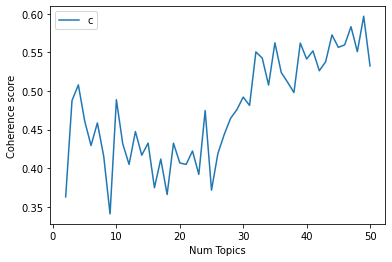

Num Topics = 2  has Coherence Value of 0.3627
Num Topics = 3  has Coherence Value of 0.4875
Num Topics = 4  has Coherence Value of 0.5079
Num Topics = 5  has Coherence Value of 0.4611
Num Topics = 6  has Coherence Value of 0.4293
Num Topics = 7  has Coherence Value of 0.4586
Num Topics = 8  has Coherence Value of 0.4154
Num Topics = 9  has Coherence Value of 0.3406
Num Topics = 10  has Coherence Value of 0.4887
Num Topics = 11  has Coherence Value of 0.4316
Num Topics = 12  has Coherence Value of 0.4048
Num Topics = 13  has Coherence Value of 0.4474
Num Topics = 14  has Coherence Value of 0.4167
Num Topics = 15  has Coherence Value of 0.4325
Num Topics = 16  has Coherence Value of 0.3745
Num Topics = 17  has Coherence Value of 0.4118
Num Topics = 18  has Coherence Value of 0.3657
Num Topics = 19  has Coherence Value of 0.4323
Num Topics = 20  has Coherence Value of 0.4067
Num Topics = 21  has Coherence Value of 0.4048
Num Topics = 22  has Coherence Value of 0.4222
Num Topics = 23  has 

In [8]:
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import matplotlib.pyplot as plt


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Args:
  
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

    Returns:
    
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    
    for num_topics in range(start, limit, step):
        
        model = LdaMulticore(corpus=corpus,
                            id2word=dictionary,
                            num_topics=num_topics, 
                            random_state=42,
                            passes=10,
                            workers=7)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts,
                                        dictionary=dictionary, 
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

texts = df['splitted_text'].to_list()
id2word = corpora.Dictionary(texts)
# id2word.filter_extremes(no_below=1000)
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=tfidf_corpus, 
                                                        texts=texts, 
                                                        start=2, 
                                                        limit=51, 
                                                        step=1)


limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [9]:
from pprint import pprint
optimal_model = model_list[5]

print('\nPerplexity: ', optimal_model.log_perplexity(tfidf_corpus))

coherence_model_lda = CoherenceModel(model=optimal_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))


Perplexity:  -9.463067929851848

Coherence Score:  0.4586006322481553
[(0,
  '0.003*"value" + 0.003*"column" + 0.002*"return" + 0.002*"like" + '
  '0.002*"string" + 0.002*"data" + 0.002*"object" + 0.002*"want" + '
  '0.002*"user" + 0.002*"function" + 0.002*"would" + 0.002*"result" + '
  '0.002*"model" + 0.002*"list" + 0.002*"error" + 0.002*"need" + 0.002*"array" '
  '+ 0.002*"get" + 0.002*"example" + 0.002*"query" + 0.002*"table" + '
  '0.002*"code" + 0.002*"name" + 0.002*"field" + 0.002*"output" + 0.002*"work" '
  '+ 0.002*"using" + 0.002*"date" + 0.002*"following" + 0.002*"time"'),
 (1,
  '0.003*"file" + 0.003*"error" + 0.002*"version" + 0.002*"command" + '
  '0.002*"module" + 0.002*"get" + 0.002*"project" + 0.002*"work" + '
  '0.002*"following" + 0.002*"using" + 0.002*"trying" + 0.002*"https" + '
  '0.002*"build" + 0.002*"server" + 0.002*"running" + 0.002*"test" + '
  '0.002*"name" + 0.002*"path" + 0.002*"service" + 0.002*"any" + '
  '0.002*"package" + 0.002*"application" + 0.002*"

In [22]:
tags = df.splitted_cleaned_tags_top_200

def format_topics_sentences(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, 
                                                  corpus=tfidf_corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.copy()
df_dominant_topic = pd.concat([df_dominant_topic, tags], axis=1)
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Original_keywords']

# Show
df_dominant_topic.head(10)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Original_keywords
0,5.0,0.8886,"text, width, column, html, color, want, value,...","[string, algorithm]"
1,0.0,0.6161,"value, column, return, like, string, data, obj...",[flutter]
2,5.0,0.8163,"text, width, column, html, color, want, value,...","[c++, flutter, dart]"
3,0.0,0.4703,"value, column, return, like, string, data, obj...","[java, json, spring-boot]"
4,3.0,0.8030,"file, work, want, like, need, function, using,...",[rust]
5,3.0,0.6741,"file, work, want, like, need, function, using,...","[react-native, expo]"
6,0.0,0.8806,"value, column, return, like, string, data, obj...",[amazon-ec2]
7,2.0,0.5239,"android, file, version, install, package, modu...",[python]
8,1.0,0.8895,"file, error, version, command, module, get, pr...","[azure, asp.net-core]"
9,5.0,0.3740,"text, width, column, html, color, want, value,...",[redis]


In [55]:
sent_topics_sorted_df = pd.DataFrame()

for i, grp in df_topic_sents_keywords.groupby('Dominant_Topic'):
    grp['Dominant_Topic'] = i
    sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, 
                                       grp.sort_values(['Perc_Contribution'],
                                                       ascending = False).head(1)], 
                                            axis=0)

sent_topics_sorted_df.reset_index(inplace = True)

# # Format
sent_topics_sorted_df.columns = ["Topic_Num_Max_Contrib", "Dominant_Topic", "Topic_Perc_Contrib", "Keywords"]

# Show
sent_topics_sorted_df

,Topic_Num_Max_Contrib,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,3388,0.0,0.9425,"value, column, return, like, string, data, obj..."
1,6017,1.0,0.9458,"file, error, version, command, module, get, pr..."
2,1841,2.0,0.9422,"android, file, version, install, package, modu..."
3,4048,3.0,0.9341,"file, work, want, like, need, function, using,..."
4,4810,4.0,0.9125,"epoch, train, model, keras, loss, layer, input..."
5,5023,5.0,0.9423,"text, width, column, html, color, want, value,..."
6,307,6.0,0.9371,"button, return, react, const, state, widget, c..."


In [62]:
df_tmp = df_topic_sents_keywords.copy()
df_tmp['Num_Documents'] = df_tmp.groupby('Dominant_Topic').Dominant_Topic.transform('count')
df_tmp['Perc_Documents'] = df_tmp.Num_Documents / df_tmp.shape[0]
df_tmp.set_index('Dominant_Topic', inplace = True) 
df_tmp = df_tmp[['Num_Documents', 'Perc_Documents']]

df_dominant_topics_prop = sent_topics_sorted_df[["Dominant_Topic","Keywords"]].copy()
df_dominant_topics_prop.set_index('Dominant_Topic', inplace = True)
df_dominant_topics_prop = df_dominant_topics_prop.join(df_tmp)
df_dominant_topics_prop.reset_index(inplace = True)
df_dominant_topics_prop.drop_duplicates(subset = ['Dominant_Topic'], inplace = True)
df_dominant_topics_prop.index = range(df_dominant_topics_prop.shape[0])

df_dominant_topics_prop

,Dominant_Topic,Keywords,Num_Documents,Perc_Documents
0,0.0,"value, column, return, like, string, data, obj...",2835,0.2835
1,1.0,"file, error, version, command, module, get, pr...",2595,0.2595
2,2.0,"android, file, version, install, package, modu...",379,0.0379
3,3.0,"file, work, want, like, need, function, using,...",1530,0.1530
4,4.0,"epoch, train, model, keras, loss, layer, input...",106,0.0106
5,5.0,"text, width, column, html, color, want, value,...",1828,0.1828
6,6.0,"button, return, react, const, state, widget, c...",727,0.0727


In [65]:
from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, tfidf_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_tfidf.html')
display(HTML('lda_tfidf.html'))

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [80]:
lda_model = optimal_model
def predict_unsupervised_tags(text):
    """
    Predict tags of a preprocessed text
    
    Args:
        text(list): preprocessed text
        
    Returns:
        relevant_tags(list): list of tags
    """
    
    corpus_new = id2word.doc2bow(text)
    topics = lda_model.get_document_topics(corpus_new)
    
    #find most relevant topic according to probability
    relevant_topic = topics[0][0]
    relevant_topic_prob = topics[0][1]
    
    for i in range(len(topics)):
        if topics[i][1] > relevant_topic_prob:
            relevant_topic = topics[i][0]
            relevant_topic_prob = topics[i][1]
            
    #retrieve associated to topic tags present in submited text
    potential_tags = lda_model.get_topic_terms(topicid=relevant_topic, topn=20)
    
    relevant_tags = [id2word[tag[0]] for tag in potential_tags if id2word[tag[0]] in text]
    
    return relevant_tags

for i in range(20):
    print(f"Liste de tags à prédire : {df.splitted_cleaned_tags_top_200.iloc[i]}\n")
    print(f"Liste des tags prédits par le modèle non supervisé: {predict_unsupervised_tags(df.splitted_text.iloc[i])}\n\n"),

Liste de tags à prédire : ['string', 'algorithm']

Liste des tags prédits par le modèle non supervisé: []


Liste de tags à prédire : ['flutter']

Liste des tags prédits par le modèle non supervisé: ['need']


Liste de tags à prédire : ['c++', 'flutter', 'dart']

Liste des tags prédits par le modèle non supervisé: ['color', 'value']


Liste de tags à prédire : ['java', 'json', 'spring-boot']

Liste des tags prédits par le modèle non supervisé: ['value', 'return', 'like', 'string', 'object', 'need']


Liste de tags à prédire : ['rust']

Liste des tags prédits par le modèle non supervisé: ['return', 'object', 'result', 'error']


Liste de tags à prédire : ['react-native', 'expo']

Liste des tags prédits par le modèle non supervisé: ['file', 'want', 'function', 'using', 'would', 'code', 'error', 'problem', 'image', 'return']


Liste de tags à prédire : ['amazon-ec2']

Liste des tags prédits par le modèle non supervisé: ['file', 'error', 'server']


Liste de tags à prédire : ['python']

Li